In [ ]:
import pandas as pd
import openslide
import tifffile as tiff
import matplotlib.pyplot as plt
import torch
import seaborn as sns

from pathlib import Path
import json

In [3]:
base_dir = Path().resolve()
base_dir

PosixPath('/home/sadegh/projects/nencki_institute/notebooks')

## Patient Measurement Analysis

In [4]:
patient_1991 = base_dir.parent / "data/measurements_1991.xlsx"
patinet_3149 = base_dir.parent / "data/measurements_3149.csv"

In [5]:
# patient 1991
raw = pd.read_excel(patient_1991, header=None)
header = raw.iloc[0,0].split(";")
raw.columns = header
col = "Cell: ALDH1L1: Median"
raw[col] = raw[col].astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]
raw[col] = pd.to_numeric(raw[col], errors="coerce")
raw = raw.iloc[3:,:]
df_1991 = raw.reset_index(drop=True)
df_1991

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
0,pHGG_1991_3149_Scan1.qptiff - resolution #1,533b814e-ea83-4609-b853-803f539f6d7a,Cell,NaN,NaN,Annotation,Polygon,9802.9,29434.9,7.1667,...,5.1875,5.0,0.0312,0.0,0.0625,0.0,0.0000,0.0,91.9375,87.5
1,pHGG_1991_3149_Scan1.qptiff - resolution #1,df62610a-34eb-4783-a4d5-cf0e1422ea4c,Cell,NaN,NaN,Annotation,Polygon,9811.3,29444.0,41.3081,...,3.9057,4.0,0.3145,0.0,0.0189,0.0,0.0440,0.0,78.6792,79.0
2,pHGG_1991_3149_Scan1.qptiff - resolution #1,b1aa9611-8c01-4076-8be8-41c004b0dd6c,Cell,NaN,NaN,Annotation,Polygon,9805.1,29451.4,49.0177,...,4.0950,4.0,0.5250,0.0,0.0100,0.0,0.1850,0.0,88.2250,95.5
3,pHGG_1991_3149_Scan1.qptiff - resolution #1,878f8f4d-2a58-4d32-b2ae-e61f110c4e96,Cell,NaN,NaN,Annotation,Polygon,9802.0,29467.5,54.7391,...,4.1396,4.0,0.4910,0.0,1.2477,0.0,0.1847,0.0,97.0045,101.0
4,pHGG_1991_3149_Scan1.qptiff - resolution #1,859744c8-8e91-4edf-991b-8e367fc810c1,Cell,NaN,NaN,Annotation,Polygon,9813.3,29470.4,59.0107,...,3.9339,4.0,0.2467,0.0,0.0044,0.0,0.1013,0.0,68.8987,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31405,pHGG_1991_3149_Scan1.qptiff - resolution #1,1d81db57-b450-4f7d-8e61-29a7499964f2,Cell,NaN,NaN,Annotation,Polygon,13444.7,28702.3,53.1763,...,5.9628,6.0,0.9860,1.0,0.0326,0.0,0.1721,0.0,100.4512,84.0
31406,pHGG_1991_3149_Scan1.qptiff - resolution #1,97110e29-2c24-4b4d-9d98-4b607c2285ca,Cell,NaN,NaN,Annotation,Polygon,12702.9,27801.7,58.2237,...,4.4895,4.0,0.5021,0.0,0.0042,0.0,0.4226,0.0,19.0586,20.0
31407,pHGG_1991_3149_Scan1.qptiff - resolution #1,554a57d3-7267-46e4-a09f-5e8b53d95599,Cell,NaN,NaN,Annotation,Polygon,13245.2,28465.8,13.0345,...,5.8302,6.0,0.8302,1.0,0.0566,0.0,0.9245,1.0,87.2076,86.0
31408,pHGG_1991_3149_Scan1.qptiff - resolution #1,19de3283-0860-454a-960e-a775eb1b9ca6,Cell,NaN,NaN,Annotation,Polygon,12396.3,28610.3,65.7426,...,9.6525,9.0,0.9151,1.0,0.0077,0.0,0.5019,0.0,75.1583,64.0


In [6]:
# patient_3149
raw = pd.read_csv(patinet_3149, header=None)   
header = raw.iloc[0, 0].split(";")
data = raw.iloc[1:, 0].str.split(";", expand=True)
data.columns = header
df_3149 = data.reset_index(drop=True)
df_3149

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,Cell: Area µm^2,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
0,pHGG_1991_3149_Scan1.qptiff - resolution #1,84099414-3e62-425a-9085-282e3e1a21ff,Cell,,,Annotation,Polygon,11200,8391.1,15.3048,...,4.1077,4,0.4769,0,0,0,0.0923,0,21.4923,21
1,pHGG_1991_3149_Scan1.qptiff - resolution #1,fc30177d-09e0-409e-992d-74629ce175ed,Cell,,,Annotation,Polygon,11186.4,8393.8,10.7628,...,3.3478,3,0.0435,0,0,0,0,0,21.087,21
2,pHGG_1991_3149_Scan1.qptiff - resolution #1,310dabff-3574-4189-95d3-f3d84678f548,Cell,,,Annotation,Polygon,11177.7,8396.1,43.6511,...,3.7127,4,0.5249,0,0,0,0.0718,0,18.2376,18
3,pHGG_1991_3149_Scan1.qptiff - resolution #1,0ee07499-3690-418e-9e36-7aad91ae371e,Cell,,,Annotation,Polygon,11203.9,8394.9,68.7307,...,5.1295,5,0.2662,0,0,0,0.0324,0,29.7914,27
4,pHGG_1991_3149_Scan1.qptiff - resolution #1,fb7cd2e6-4853-4c72-9947-1d818f5dd069,Cell,,,Annotation,Polygon,11191,8396.8,83.7356,...,4.7654,5,0.0587,0,0,0,0.7683,0,15.6246,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210548,pHGG_1991_3149_Scan1.qptiff - resolution #1,45dcefff-1dc0-4f66-b57a-673b3f3f623b,Cell,,,Annotation,Polygon,14876.7,13381.4,47.9196,...,7.715,8,1.1192,1,0.0207,0,0.1347,0,170.1347,167
210549,pHGG_1991_3149_Scan1.qptiff - resolution #1,6405fd5b-8e04-49ca-a121-fc0cc80d4771,Cell,,,Annotation,Polygon,15572.4,13598.9,30.4987,...,2.9297,3,0.8438,1,0.0234,0,0.1094,0,148.2266,142
210550,pHGG_1991_3149_Scan1.qptiff - resolution #1,ed7ac5ab-f6f4-4ff5-bb8c-b0b69f2f9ea2,Cell,,,Annotation,Polygon,14641,14067.6,61.5644,...,2.1734,2,1.0927,1,0.0081,0,0.1452,0,134.9839,135
210551,pHGG_1991_3149_Scan1.qptiff - resolution #1,d8ac877d-1955-4fc6-8f9d-93d86c423df5,Cell,,,Annotation,Polygon,14772.3,13626,23.1197,...,2.44,2,0.59,0,0,0,0.06,0,251.36,255


## EDA on datasets

In [7]:
data = df_1991 # or df_3149

In [8]:
data.describe()

,Name,Classification,Centroid X µm,Centroid Y µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,Cell: Solidity,Nucleus: DAPI: Mean,Nucleus: DAPI: Median,...,Cell: LGALS3: Mean,Cell: LGALS3: Median,Cell: PD-1: Mean,Cell: PD-1: Median,Cell: MOG: Mean,Cell: MOG: Median,Cell: SPP1: Mean,Cell: SPP1: Median,Cell: ALDH1L1: Mean,Cell: ALDH1L1: Median
count,0.0,0.0,31410.000000,31410.000000,31410.000000,31410.000000,31344.000000,31410.000000,27963.000000,27963.000000,...,31386.000000,31386.000000,31386.000000,31386.000000,31386.000000,31386.000000,31386.000000,31386.000000,31386.000000,31386.000000
mean,NaN,NaN,11177.489147,29474.697233,66.210897,38.549907,0.535345,0.915145,64.425180,64.291457,...,4.790319,4.677643,1.186734,1.040289,0.101269,0.008762,0.359449,0.055917,73.158253,70.776429
std,NaN,NaN,1410.558608,857.788410,31.353450,10.236641,0.066969,0.039094,21.755752,23.118407,...,2.789700,2.731812,0.547456,0.626618,0.493504,0.295044,0.245979,0.237034,37.478563,36.617618
min,NaN,NaN,8532.300000,27683.800000,0.001300,0.173400,0.016400,0.049400,13.045000,13.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.333300,1.000000
25%,NaN,NaN,10166.000000,28807.625000,43.506525,31.996100,0.502700,0.906400,47.967000,47.000000,...,3.119775,3.000000,0.841100,1.000000,0.014300,0.000000,0.207725,0.000000,44.079400,42.625000
50%,NaN,NaN,10674.950000,29471.200000,62.999750,38.009800,0.546400,0.924000,63.535500,63.000000,...,4.543700,4.000000,1.130050,1.000000,0.030100,0.000000,0.305400,0.000000,71.543050,69.000000
75%,NaN,NaN,12670.100000,30143.875000,84.499575,44.998000,0.580800,0.935700,78.475450,79.000000,...,6.018450,6.000000,1.461300,1.000000,0.056800,0.000000,0.448100,0.000000,96.253675,93.000000
max,NaN,NaN,13669.800000,31327.500000,304.509200,104.009800,0.785400,1.000000,198.833300,231.000000,...,33.179300,32.000000,15.200000,15.000000,30.080800,24.000000,7.617600,6.000000,249.353700,255.000000


In [9]:
data.columns

Index(['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent',
       'ROI', 'Centroid X µm', 'Centroid Y µm', 'Cell: Area µm^2',
       'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity',
       'Nucleus: DAPI: Mean', 'Nucleus: DAPI: Median', 'Nucleus: H3K27M: Mean',
       'Nucleus: H3K27M: Median', 'Nucleus: Ki67: Mean',
       'Nucleus: Ki67: Median', 'Cell: GLUT1: Mean', 'Cell: GLUT1: Median',
       'Cell: GFAP: Mean', 'Cell: GFAP: Median', 'Cell: CD163: Mean',
       'Cell: CD163: Median', 'Cell: SOX4: Mean', 'Cell: SOX4: Median',
       'Cell: CD31: Mean', 'Cell: CD31: Median', 'Cell: TMEM119: Mean',
       'Cell: TMEM119: Median', 'Cell: HLA-A: Mean', 'Cell: HLA-A: Median',
       'Cell: CD68: Mean', 'Cell: CD68: Median', 'Cell: CD20: Mean',
       'Cell: CD20: Median', 'Cell: CD8: Mean', 'Cell: CD8: Median',
       'Cell: GPNMB: Mean', 'Cell: GPNMB: Median', 'Cell: PD-L1: Mean',
       'Cell: PD-L1: Median', 'Cell: CD45RO: Mean', 'Cell: CD45RO: Median',

In [10]:
for col in data.columns:
    if "Mean" in col or "Median" in col:
        data[col] = pd.to_numeric(data[col], errors="coerce")

In [11]:
markers = ["SPP1", "TMEM119", "CD68", "CD45", "LGALS3", "H3K27M", "GLUT1", "CD31"]

TH = {}
for m in markers:
    col = f"Cell: {m}: Mean" if m != "H3K27M" else f"Nucleus: {m}: Mean"
    vals = data[col].dropna()
    if len(vals) == 0:
        continue
    try:
       TH[m] = threshold_otsu(vals)   
    except:
       TH[m] = vals.median()        
TH

{'SPP1': np.float64(0.3054),
 'TMEM119': np.float64(6.8559),
 'CD68': np.float64(4.992),
 'CD45': np.float64(11.55425),
 'LGALS3': np.float64(4.5437),
 'H3K27M': np.float64(26.1598),
 'GLUT1': np.float64(5.9388),
 'CD31': np.float64(1.4324)}

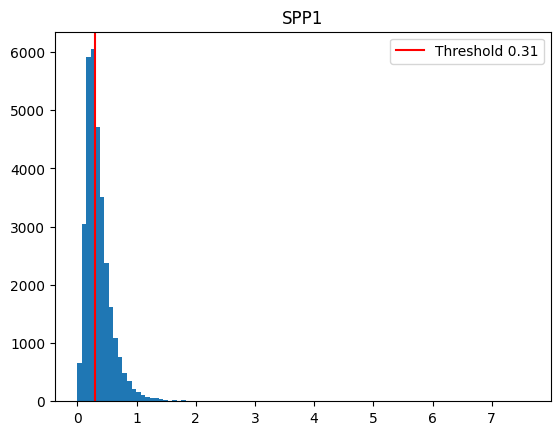

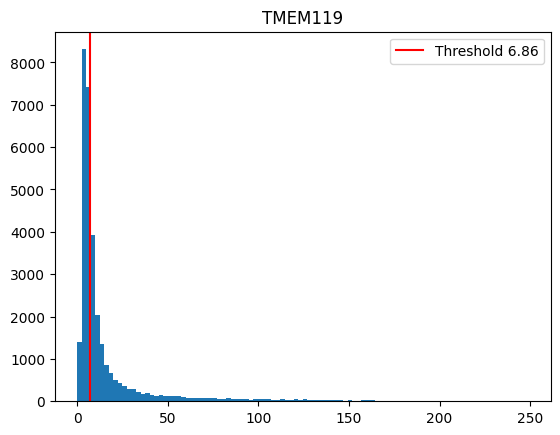

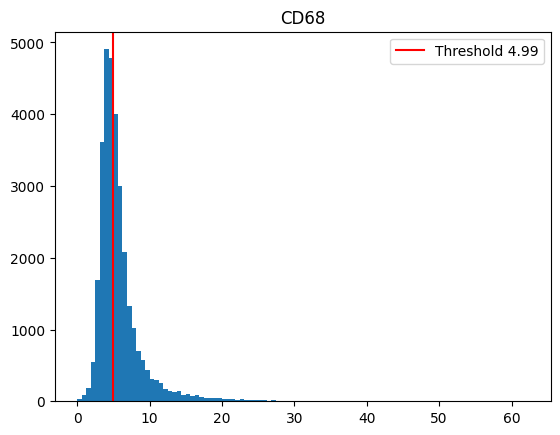

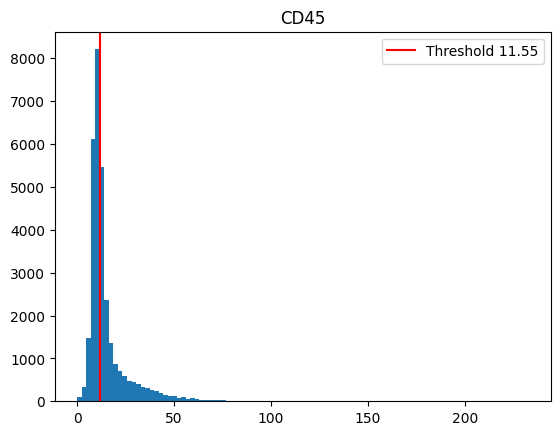

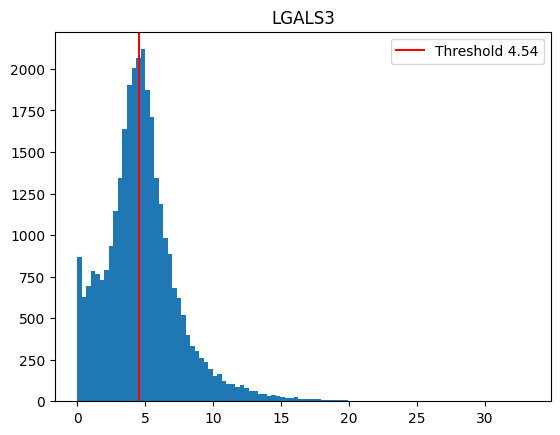

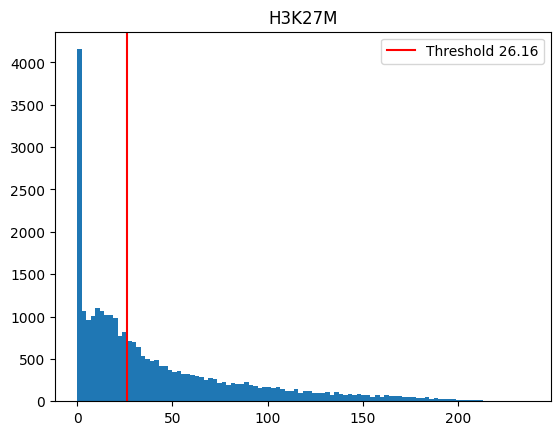

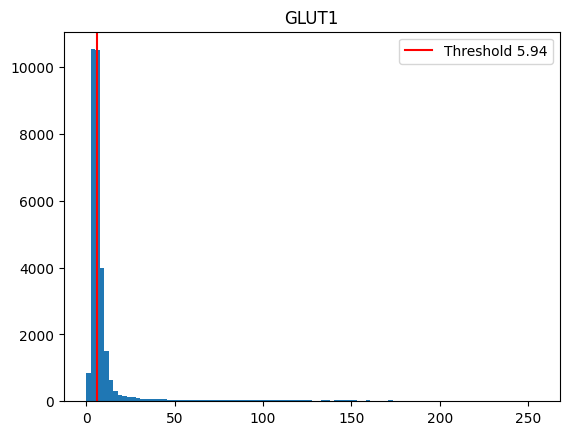

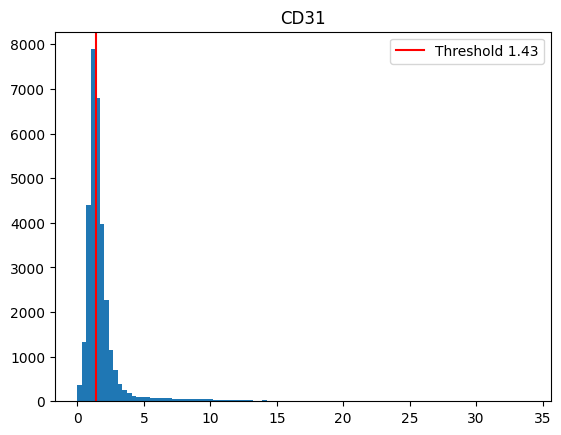

In [12]:
for m in ["SPP1", "TMEM119", "CD68", "CD45", "LGALS3", "H3K27M", "GLUT1", "CD31"]:
    col = f"Cell: {m}: Mean" if m != "H3K27M" else f"Nucleus: {m}: Mean"
    vals = data[col].dropna()
    plt.hist(vals, bins=100)
    plt.axvline(TH[m], color='red', label=f"Threshold {TH[m]:.2f}")
    plt.title(m)
    plt.legend()
    plt.show()

In [13]:
def pos(data, marker, nucleus=False):
    col = f"Nucleus: {marker}: Mean" if nucleus else f"Cell: {marker}: Mean"
    return data[col] > TH[marker]

In [22]:
# # Definition of cell-type and condition-specific masks based on marker expression:
# - microglia_like: TMEM119+ CD68+ CD45+ (resident brain microglia with immune activity)
# - macrophage_like: LGALS3+ CD68+ CD45+ (infiltrating/activated macrophages)
# - h3k27m: H3K27M mutation marker in the nucleus (tumor-specific histone mutation)
# - hypoxic: GLUT1+ and CD31- (hypoxic tissue cells, non-endothelial)
microglia_like = pos(data, "TMEM119") & pos(data, "CD68") & pos(data, "CD45")
macrophage_like = pos(data, "LGALS3") & pos(data, "CD68") & pos(data, "CD45")
h3k27m = pos(data, "H3K27M", nucleus=True)
hypoxic = pos(data, "GLUT1") & (~pos(data, "CD31"))

results = {}

results["SPP1 in TMEM119+ CD68+ CD45+"] = (data.loc[microglia_like, "Cell: SPP1: Mean"] > TH["SPP1"]).mean() * 100
results["SPP1 in LGALS3+ CD68+ CD45+"] = (data.loc[macrophage_like, "Cell: SPP1: Mean"] > TH["SPP1"]).mean() * 100
results["SPP1 in H3K27M+"] = (data.loc[h3k27m, "Cell: SPP1: Mean"] > TH["SPP1"]).mean() * 100

results["SPP1 in TMEM119+ CD68+ CD45+ GLUT1+ CD31-"] = (data.loc[microglia_like & hypoxic, "Cell: SPP1: Mean"] > TH["SPP1"]).mean() * 100
results["SPP1 in LGALS3+ CD68+ CD45+ GLUT1+ CD31-"] = (data.loc[macrophage_like & hypoxic, "Cell: SPP1: Mean"] > TH["SPP1"]).mean() * 100
results["SPP1 in H3K27M+ GLUT1+ CD31-"] = (data.loc[h3k27m & hypoxic, "Cell: SPP1: Mean"] > TH["SPP1"]).mean() * 100

summary = pd.DataFrame.from_dict(results, orient="index", columns=["% SPP1+"])
summary["% SPP1+"] = summary["% SPP1+"].fillna("No cells")
summary.reset_index(inplace=True, names=["Group"])
summary

# Save summary
# summary.to_csv("SPP1_percentages_summary.csv")


,Group,% SPP1+
0,SPP1 in TMEM119+ CD68+ CD45+,70.289360
1,SPP1 in LGALS3+ CD68+ CD45+,67.371184
2,SPP1 in H3K27M+,54.910235
3,SPP1 in TMEM119+ CD68+ CD45+ GLUT1+ CD31-,63.862928
4,SPP1 in LGALS3+ CD68+ CD45+ GLUT1+ CD31-,54.335260
5,SPP1 in H3K27M+ GLUT1+ CD31-,51.317891


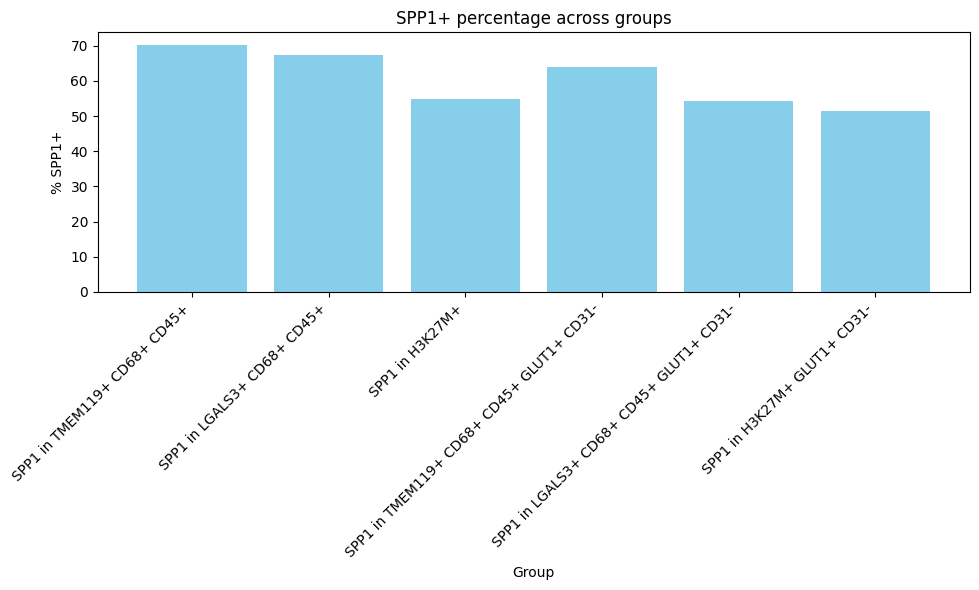

In [27]:
plt.figure(figsize=(10,6))
plt.bar(summary["Group"], summary["% SPP1+"], color="skyblue")

plt.ylabel("% SPP1+")
plt.xlabel("Group")
plt.title("SPP1+ percentage across groups")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

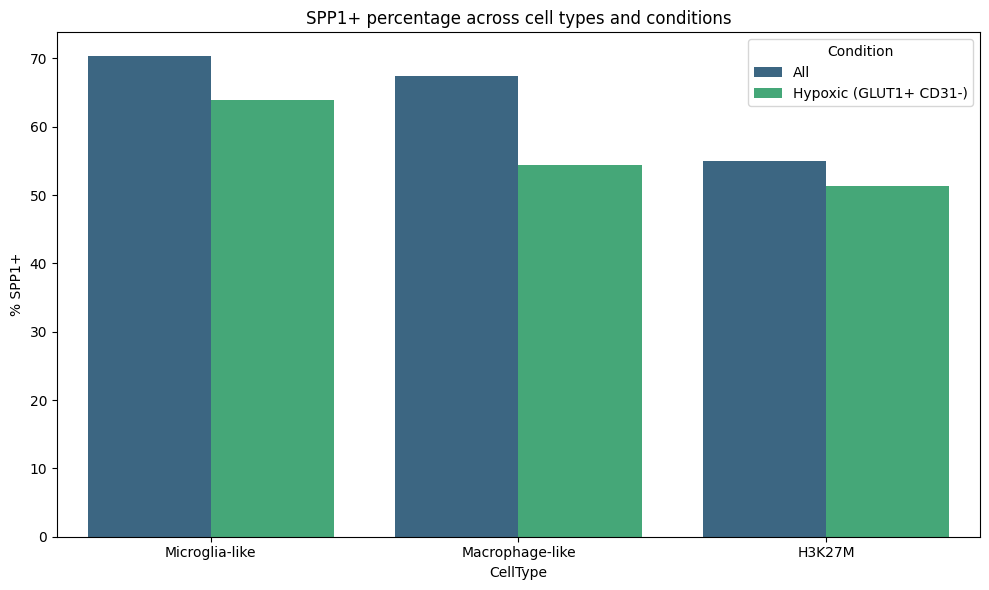

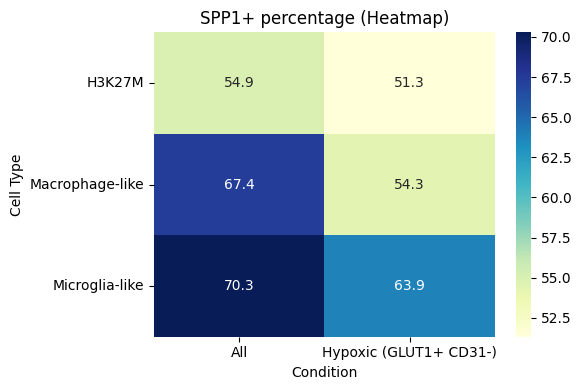

In [ ]:
summary = summary.copy()
summary["CellType"] = summary["Group"].apply(
    lambda x: "Microglia-like" if "TMEM119" in x 
    else "Macrophage-like" if "LGALS3" in x 
    else "H3K27M"
)
summary["Condition"] = summary["Group"].apply(
    lambda x: "Hypoxic (GLUT1+ CD31-)" if "GLUT1" in x else "All"
)

# -----------------------
# Grouped Bar Plot
# -----------------------
plt.figure(figsize=(10,6))
sns.barplot(
    data=summary,
    x="CellType",
    y="% SPP1+",
    hue="Condition",
    palette="viridis"
)
plt.ylabel("% SPP1+")
plt.title("SPP1+ percentage across cell types and conditions")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

# -----------------------
# Heatmap
# -----------------------
heatmap_data = summary.pivot(index="CellType", columns="Condition", values="% SPP1+")

plt.figure(figsize=(6,4))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("SPP1+ percentage (Heatmap)")
plt.ylabel("Cell Type")
plt.xlabel("Condition")
plt.tight_layout()
plt.show()


# quPath Json Data

In [15]:
summary_path = base_dir.parent / "qupath/1991_Diffuse midline glioma H3K27M/data/1/summary.json"
with open(summary_path, "r") as f:
    summary = json.load(f)
summary

{'timestamp': 1754464230651,
 'imageType': 'FLUORESCENCE',
 'server': {'width': 36480,
  'height': 64800,
  'sizeC': 30,
  'sizeZ': 1,
  'sizeT': 1},
 'hierarchy': {'nObjects': 31417,
  'objectTypeCounts': {'Root objects': 1, 'Annotations': 4, 'Cells': 31412},
  'annotationClassificationCounts': {'Unclassified': 4},
  'detectionClassificationCounts': {'Unclassified': 31412}}}

In [16]:
server_path = base_dir.parent / "qupath/1991_Diffuse midline glioma H3K27M/data/1/server.json"
with open(server_path, "r") as f:
    server = json.load(f)
server

{'builderType': 'uri',
 'providerClassName': 'qupath.lib.images.servers.bioformats.BioFormatsServerBuilder',
 'uri': 'file:/D:/AKOYA_CD163/1991_4149/pHGG_1991_3149_Scan1.qptiff',
 'args': ['--series', '0'],
 'metadata': {'name': 'pHGG_1991_3149_Scan1.qptiff - resolution #1',
  'width': 36480,
  'height': 64800,
  'sizeZ': 1,
  'sizeT': 1,
  'channelType': 'DEFAULT',
  'isRGB': False,
  'pixelType': 'UINT8',
  'levels': [{'downsample': 1.0, 'width': 36480, 'height': 64800},
   {'downsample': 2.0, 'width': 18240, 'height': 32400},
   {'downsample': 4.0, 'width': 9120, 'height': 16200},
   {'downsample': 8.0, 'width': 4560, 'height': 8100},
   {'downsample': 16.0, 'width': 2280, 'height': 4050},
   {'downsample': 32.0, 'width': 1140, 'height': 2025}],
  'channels': [{'name': 'DAPI', 'color': -16776961},
   {'name': 'GLUT1', 'color': -256},
   {'name': 'GFAP', 'color': -32768},
   {'name': 'CD163', 'color': -16711681},
   {'name': 'SOX4', 'color': -65281},
   {'name': 'CD31', 'color': -256

In [17]:
classes_path = base_dir.parent / "qupath/1991_Diffuse midline glioma H3K27M/classifiers/classes.json"
with open(classes_path, "r") as f:
    classes = json.load(f)
classes

{'pathClasses': [{'name': 'Tumor', 'color': -3670016},
  {'name': 'Stroma', 'color': -6895466},
  {'name': 'Immune cells', 'color': -6268256},
  {'name': 'Necrosis', 'color': -13487566},
  {'name': 'Other', 'color': -14336},
  {'name': 'Region*', 'color': -16777036},
  {'name': 'Ignore*', 'color': -4934476},
  {'name': 'Positive', 'color': -377282},
  {'name': 'Negative', 'color': -9408287}]}